# Biased moments of undersampled sources
<br>Owner(s): **Andrew Bradshaw** ([@andrewkbradshaw](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@andrewkbradshaw))
<br>Last Verified to Run: **2019-08-09**
<br>Verified Stack Release: **18.0**

This notebook demonstrates how the measurement of centroid, size, and orientation angles of small sources (relative to the pixel grid) are biased due to undersampling and/or assumptions in the method of analysis. A possible improvement, in the form of a modified weight function, is shown to have a positive effect.

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Simulate stars and galaxies with a variety of properties, including sub-pixel centroid, size, and orientation angle.
2. Measure the centroid, size, and orientation angle using a variety of algorithms.

### References:
* [galsim.Shear](http://galsim-developers.github.io/GalSim/_build/html/shear.html) - Documentation on how GalSim defines shear
* [galsim.hsm](http://galsim-developers.github.io/GalSim/_build/html/hsm.html) - GalSim routines for adaptive moment estimation 

### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

In [1]:
# list the current running version of the stack
! eups list -s lsst_distrib

   20.0.0     	current v20_0_0 setup


In [2]:
import time,os
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import galsim
from galsim.hsm import FindAdaptiveMom as FAM
galsim.meta_data.share_dir = galsim.__file__.replace('lib/python/galsim/__init__.py','share/galsim/')

from matplotlib.colors import LogNorm
### GALSIM Fe55 sigma=.2 microns = 1/50 pix = .004 arcsec, 1620 electrons

## Functions to make images

We start by setting up a class that uses [GalSim](http://galsim-developers.github.io/GalSim/_build/html/index.html) to generate simulated images and sources. GalSim can provide various levels of realism  (e.g., readout noise, sky background, silicon sensor effects, etc.), and these are configurable during the creation of an instance. We also implement a function to use GalSim to generate a Gaussian source with a given centroid, ellipticity, and orientation.

We break up the creation of the `undersampled_galsim` class so that the various components can be explored in turn, rather than as one monolithic block. To do this, we subclass the existing class and add new methods.

In [3]:
class UndersampledGalSim:
    """
    A class to initialize galsim with a given set of parameters and make mosaics of objects.
    Most initial settings are intended to simulate typical LSST conditions, see the URL
    https://docushare.lsst.org/docushare/dsweb/View/Collection-2251
    """

In [4]:
class UndersampledGalSim(UndersampledGalSim):
    def __init__(self,method_of_imaging='phot',read_noise=10.0,sky_level_pixel=500,
                 diffusion_factor=0,stamp_width=31,pixel_scale=0.2,gain=1,
                 rngseed=8675309,do_hsm_moments_truefalse=False,sim_sensor_truefalse=False,
                 default_gsparams=True):
        """Initialize the imager with some basic settings"""
        self.method = method_of_imaging           # default: phot, fft; no_pixel' might take forever?
        self.sensor = sim_sensor_truefalse        # whether or not to simulate the sensor & diffusion
        self.pixel_scale=pixel_scale              # pixel scale in arcsec/pixel, LSST = 0.2
        self.stamp_width=stamp_width              # width of each postage stamp, default 31
        self.gain=gain                            # CCD gain, default 1
        self.read_noise=read_noise                # Gaussian std dev. of CCD readout noise
        self.sky_level_pixel=sky_level_pixel      # the background noise level (subtracted off)
        self.rng = galsim.UniformDeviate(rngseed) # initializing the random number generator
        # galsim accuracy vs. speed tradeoffs; use provided, unless default is True then use the below
        if default_gsparams:
            self.gsparams = galsim.GSParams(
                folding_threshold=1.e-2, # maximum fractional flux that may be folded around edge of FFT
                maxk_threshold=2.e-3,    # k-values less than this may be excluded off edge of FFT
                xvalue_accuracy=1.e-6,   # approximations in real space aim to be this accurate
                kvalue_accuracy=1.e-4,   # approximations in fourier space aim to be this accurate
                shoot_accuracy=1.e-6,    # approximations in photon shooting aim to be this accurate
                minimum_fft_size=64)     # minimum size of ffts
        else: self.gsparams=default_gsparams
        self.do_hsm = do_hsm_moments_truefalse
        # initialize a blank image with the above settings
        self.image = galsim.ImageF(stamp_width, stamp_width, scale=self.pixel_scale)
        if self.sensor==True:
            self.sensor = galsim.sensor.SiliconSensor(rng=self.rng, diffusion_factor=diffusion_factor)
        else:
            self.sensor = None
        
    def draw_gaussian(self,offset=(0.0,0.0),gal_sigma_pix=1.5,gal_ellip=0,
                      gal_angle_deg=0,gal_flux=1e5):
        """Draw a Gauassian on the image, using the provided centroid offsets, widths, ellipticity
        angle, and flux. Returns the galsim object and HSM moments (if do_hsm is set to True)"""
        gal = galsim.Gaussian(sigma = gal_sigma_pix*self.pixel_scale, gsparams=self.gsparams)
        gal_shape = galsim.Shear(e=gal_ellip, beta=gal_angle_deg * galsim.degrees)
        gal = gal.shear(gal_shape)
        gal = gal.withFlux(gal_flux)
        # draw the Gaussian on the image, note that use_true_center=False 
        #  preserves sub-pixel offset in even-sized images
        final = gal.drawImage(self.image, method=self.method,offset=offset,sensor=self.sensor,
                              use_true_center=False)
        # add random read and sky noise (and subtract off the mean)
        noise = galsim.CCDNoise(self.rng, gain=self.gain, read_noise=self.read_noise, 
                                sky_level=self.sky_level_pixel)
        final.addNoise(noise)
        
        # Adaptive moments, galsim.hsm.FindAdaptiveMom as FAM
        # could sadd guess_sig=1 and parameters hsmparams=f
        if self.do_hsm==True: hsm=FAM(final)
        else: hsm=False
        return final,hsm

## Functions to compute first and second moments on images

In [5]:
def calc_firstmoms(img,coord,winsize,thresh,gwin_sig):
    #print(img[:5,:5],coord,winsize,thresh,gwin_sig)
    """Calculates the x and y first moments of the image windowed by winsize at
    coord (x,y), weighted with a Gaussian of width gwin_sig"""
    xc,yc=coord
    xmom,ymom=0.,0.
    thesum=0.
    
    i0=int(round(xc)-winsize)
    j0=int(round(yc)-winsize)
    for i in range(2*winsize):
        for j in range(2*winsize):
            if img[j0+j,i0+i]>thresh:
                gwt=np.exp(-((xc-(i0+i))**2+(yc-(j0+j))**2)/(2.*gwin_sig**2))
                thesum+=img[j0+j,i0+i]*gwt
                xmom+=img[j0+j,i0+i]*((i0+i))*gwt
                ymom+=img[j0+j,i0+i]*((j0+j))*gwt
    if thesum>0:
        xmom= xmom/thesum
        ymom= ymom/thesum
    else:
        rmom=xmom=ymom=xymom=np.NaN
    return xmom, ymom

def calc_secmoms_gwin(img,coord,winsize,thresh,gwin_sig):
    """Calculates the x, y, xy, and radial second moments of the image windowed by
    winsize at coord (x,y) and thresholded at thresh, weighted by a Gaussian of 
    width gwin_sig"""
    xc,yc=coord
    r2mom,x2mom,y2mom,xy2mom=0.,0.,0.,0.
    thesum=0.
    
    i0=int(round(xc)-winsize)
    j0=int(round(yc)-winsize)
    #print i0,j0,winsize
    for i in range(2*winsize):
        for j in range(2*winsize):
            i1,j1=i0+i,j0+j
            if img[j1,i1]>thresh:
                gwt=np.exp(-.5*((xc-(i1))**2+(yc-(j1))**2)/(gwin_sig**2))
                thesum+=img[j1,i1]*gwt
                r2mom+=img[j1,i1]*((xc-(i1))**2+(yc-j1)**2)*gwt
                x2mom+=img[j1,i1]*(xc-(i1))**2*gwt
                y2mom+=img[j1,i1]*(yc-(j1))**2*gwt
                xy2mom+=img[j1,i1]*(((i1)-xc)*((j1)-yc))*gwt
    if thesum>0:
        rmom = np.sqrt((r2mom/thesum))
        xmom= np.sqrt(2.*x2mom/thesum)
        ymom= np.sqrt(2.*y2mom/thesum)
        xyz=xy2mom/thesum*4.
        xymom= xyz#/abs(xyz)*np.sqrt(abs(xyz))
    else:
        rmom=xmom=ymom=xymom=np.NaN
    return rmom, xmom, ymom, xymom

def calc_gauss_diff(i,j,xcen,ycen,sigx,sigy):
    ydiff=1./24.*(((i-xcen)**2/sigx**2-1.)/sigx**2 + ((j-ycen)**2/sigy**2-1.)/sigy**2)
    ygauss=np.exp(-.5*((i-xcen)**2/sigx**2))*np.exp(-.5*((j-ycen)**2/sigy**2))
    return ydiff*ygauss


def calc_secmoms_corr(img,coord,winsize,thresh,gwin_sig,sigx,sigy):
    """Calculates the x, y, xy, and radial second moments of the image windowed by
    winsize at coord (x,y) and thresholded at thresh, weighted by a Gaussian of 
    width gwin_sig and corrected for pixelization using calc_gauss_diff"""
    xc,yc=coord
    r2mom,x2mom,y2mom,xy2mom=0.,0.,0.,0.
    thesum=0.
    
    i0=int(round(xc)-winsize)
    j0=int(round(yc)-winsize)
    #amp=np.max(img[j0:j0+winsize,i0:i0+winsize])
    #print(amp,np.max(img[j0:j0+winsize,i0:i0+winsize]))
    for i in range(2*winsize):
        for j in range(2*winsize):
            i1,j1=i0+i,j0+j
            if img[j1,i1]>thresh:
                imgdiff=calc_gauss_diff(i1,j1,xc,yc,sigx,sigy)
                #img[j1,i1]-=imgdiff*amp#*.01
                gwt=np.exp(-.5*((xc-(i1))**2+(yc-(j1))**2)/(gwin_sig**2))-imgdiff
                imgval=img[j1,i1]*gwt
                thesum+=imgval#img[j1,i1]*gwt
                
                r2mom+=imgval*((xc-(i1))**2+(yc-j1)**2)
                x2mom+=imgval*(xc-(i1))**2
                y2mom+=imgval*(yc-(j1))**2
                xy2mom+=imgval*(((i1)-xc)*((j1)-yc))
    if thesum>0:
        rmom = np.sqrt((r2mom/thesum))
        xmom= np.sqrt(2.*x2mom/thesum)
        ymom= np.sqrt(2.*y2mom/thesum)
        xyz=xy2mom/thesum
        xymom= xyz/abs(xyz)*np.sqrt(abs(xyz))
    else:
        rmom=xmom=ymom=xymom='NaN'
    return rmom, xmom, ymom, xymom



### Making and dispalying two postage stamps

In [6]:
def calc_and_print_moments(stamp,hsm):
    x_hsm,y_hsm,sig_hsm=hsm.moments_centroid.x,hsm.moments_centroid.y,hsm.moments_sigma
    # calculate my moments
    thresh=0
    gwin_sig=sig_hsm
    winsize=np.int(np.floor(np.min(stamp.shape))/2.)-1
    x_mymom,y_mymom=calc_firstmoms(stamp,(x_hsm-1,y_hsm-1),winsize=winsize,thresh=thresh,gwin_sig=gwin_sig)
    r2_mymom,x2_mymom,y2_mymom,xy_mymom=calc_secmoms_gwin(stamp,(x_mymom,y_mymom),winsize=winsize,thresh=thresh,gwin_sig=gwin_sig)
    r2_mymom2,x2_mymom2,y2_mymom2,xy_mymom2=calc_secmoms_gwin(stamp,(x_mymom,y_mymom),winsize=winsize,thresh=thresh,gwin_sig=gal_sigma_pix)
    r2_foo,x2_foo,y2_foo,xy_foo=calc_secmoms_corr(stamp,(x_mymom,y_mymom), winsize,thresh,gal_sigma_pix,gal_sigma_pix,gal_sigma_pix)#r2_mymom,x2_mymom,y2_mymom)
    print("X,Y positions for HSM:  ",'%.4f'%(x_hsm),'%.4f'%(y_hsm))
    print("X,Y positions for mine: ",'%.4f'%(x_mymom),'%.4f'%(y_mymom))
    print("2nd radial moment for HSM adaptive moments:  ",'%.4f'%(sig_hsm))
    print("2nd r,x,y moments for Gaussian weighted with HSM sigma: ", '%.4f'%(r2_mymom),'%.4f'%(x2_mymom),'%.4f'%(y2_mymom))
    print("2nd r,x,y moments for Gaussian weighted with input sigma: ", '%.4f'%(r2_mymom2),'%.4f'%(x2_mymom2),'%.4f'%(y2_mymom2))
    print("2nd r,x,y moments with undersampling correction: ", '%.4f'%(r2_foo),'%.4f'%(x2_foo),'%.4f'%(y2_foo))

X,Y positions for HSM:   10.9998 10.9993
X,Y positions for mine:  9.9998 9.9993
2nd radial moment for HSM adaptive moments:   1.2348
2nd r,x,y moments for Gaussian weighted with HSM sigma:  1.2348 1.2356 1.2340
2nd r,x,y moments for Gaussian weighted with input sigma:  1.2170 1.2178 1.2162
2nd r,x,y moments with undersampling correction:  1.1993 1.2001 1.1985
X,Y positions for HSM:   11.5000 11.4997
X,Y positions for mine:  10.5000 10.4997
2nd radial moment for HSM adaptive moments:   1.2352
2nd r,x,y moments for Gaussian weighted with HSM sigma:  1.2352 1.2353 1.2351
2nd r,x,y moments for Gaussian weighted with input sigma:  1.2172 1.2173 1.2171
2nd r,x,y moments with undersampling correction:  1.1995 1.1996 1.1994


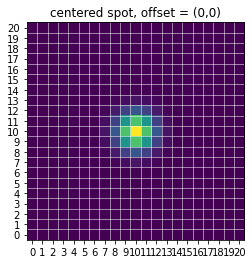

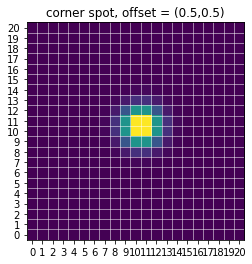

In [7]:
stamp_width=21
gal_sigma_pix=1.2  # HSM algorithm bombs at sigma<0.8
gal_flux=1e7
read_noise=0.
sky_level_pixel=0.
do_hsm_moments_truefalse=True  
ugal=UndersampledGalSim(stamp_width=stamp_width,do_hsm_moments_truefalse=do_hsm_moments_truefalse,
                         read_noise=read_noise,sky_level_pixel=sky_level_pixel)

# Display Gaussians centered at (0,0) and (0.5,0.5)
# NOTE: galsim & HSM indexes pixels starting at 1 and pixel centers are at integers
# and numpy calculations are indexed at 0 and imshow defaults to edges at half integers
def imshow_stamp_grid(stamp):
    plt.imshow(stamp,origin='lower')#,norm=LogNorm(vmin=1)),plt.colorbar()
    plt.xticks(np.arange(0,stamp.shape[1])),plt.yticks(np.arange(0,stamp.shape[0]))
    for i in range(stamp.shape[1]): plt.axvline(i-.5,color='w',lw=.5)
    for j in range(stamp.shape[0]): plt.axhline(j-.5,color='w',lw=.5)


plt.title('centered spot, offset = (0,0)')
gal,hsm=ugal.draw_gaussian(offset=(0.0,0.0),gal_sigma_pix=gal_sigma_pix,gal_flux=gal_flux)
imshow_stamp_grid(gal.array)
calc_and_print_moments(gal.array,hsm)

plt.figure()
plt.title('corner spot, offset = (0.5,0.5)')
gal,hsm=ugal.draw_gaussian(offset=(0.5,0.5),gal_sigma_pix=gal_sigma_pix,gal_flux=gal_flux)
imshow_stamp_grid(gal.array)
calc_and_print_moments(gal.array,hsm)

## Making mosaics of objects

In [8]:
class UndersampledGalSim(UndersampledGalSim):
    def make_minmax_catalog(self,n_per_side=5,offsetx_minmax=(-.5,.5),offsety_minmax=(-.5,.5),
                            sigma_minmax=(1,2),ell_minmax=(0,.9),
                            angle_minmax=(-90,90),flux_minmax=(1e4,1e4)):
        """Makes an input catalog of x/y subpixel locations, sizes (sigma), ellipticity, angle, and flux"""
        n_stamps=n_per_side**2
        cat_in = np.zeros(n_stamps, dtype={'names':('x','y','xsub','ysub',
                                                    'sigma','ell','angle','flux',
                                                    'sigma_hsm','ell_hsm','angle_hsm','flux_hsm',
                                                    'xc_hsm','yc_hsm'),
                                           'formats':('f8','f8','f8','f8',
                                                      'f8','f8','f8','f8',
                                                      'f8','f8','f8','f8',
                                                      'f8','f8')})

        cat_in['xsub']=np.linspace(offsetx_minmax[0],offsetx_minmax[1],n_stamps)
        cat_in['ysub']=np.linspace(offsety_minmax[0],offsety_minmax[1],n_stamps)
        cat_in['sigma']=np.linspace(sigma_minmax[0],sigma_minmax[1],n_stamps)
        cat_in['ell']=np.linspace(ell_minmax[0],ell_minmax[1],n_stamps)
        cat_in['angle']=np.linspace(angle_minmax[0],angle_minmax[1],n_stamps)
        cat_in['flux']=np.linspace(flux_minmax[0],flux_minmax[1],n_stamps)
        return cat_in

    def make_mosaic(self,cat_in):
        """Takes an input catalog made by make_minmax_catalog and mosaics the postage stamps into a larger array, 
        suitable for processing by automatic routines"""
        n_stamps=len(cat_in)
        n_per_side=np.int(np.floor(np.sqrt(n_stamps)))
        mosaic_width=n_per_side*self.stamp_width
        mosaic=np.empty((mosaic_width,mosaic_width))
        mosaic[:]=np.nan
        for i in range(n_per_side):
            for j in range(n_per_side):
                k=i+j*n_per_side
                gal,hsm=self.draw_gaussian(offset=(cat_in['xsub'][k],cat_in['ysub'][k]), 
                                           gal_sigma_pix=cat_in['sigma'][k], gal_ellip=cat_in['ell'][k], 
                                           gal_angle_deg=cat_in['angle'][k],gal_flux=cat_in['flux'][k],
                                           )
                w=self.stamp_width
                mosaic[j*w:(j+1)*w,i*w:(i+1)*w]=gal.array
                cat_in['x'][k]=(i+.5)*w + cat_in['xsub'][k]-.5
                cat_in['y'][k]=(j+.5)*w + cat_in['ysub'][k]-.5
                if self.do_hsm==True:
                    cat_in['xc_hsm'],cat_in['yc_hsm']=hsm.moments_centroid.x,hsm.moments_centroid.y
                    cat_in['sigma_hsm'][k]=hsm.moments_sigma
                    cat_in['angle_hsm'][k]=hsm.observed_shape.beta.rad
                    cat_in['flux_hsm'][k]=hsm.moments_amp
        return mosaic,cat_in

(<matplotlib.image.AxesImage at 0x7f20bc7dd390>,
 <matplotlib.colorbar.Colorbar at 0x7f20bc78ef10>)

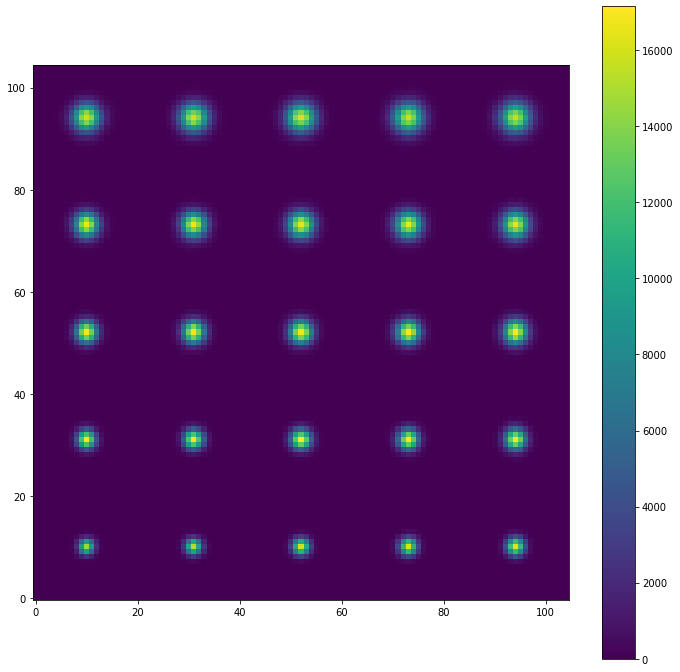

In [9]:
# set up the galsim imager
stamp_width=21
read_noise=0.0
sky_level_pixel=0.0
ugal=UndersampledGalSim(stamp_width=stamp_width,read_noise=read_noise,sky_level_pixel=sky_level_pixel,do_hsm_moments_truefalse=True)

# make the catalog using the given min/max parameters
sigma_minmax=(1.,2.)
ell_minmax=(0,0)
offsetx_minmax,offsety_minmax=(0,0),(0,0)
angle_minmax=(-90,90)
flux_minmax=(1e5,4e5)
cat_in=ugal.make_minmax_catalog(n_per_side=5,offsetx_minmax=offsetx_minmax,offsety_minmax=offsety_minmax,
                                sigma_minmax=sigma_minmax,ell_minmax=ell_minmax,
                                angle_minmax=angle_minmax,flux_minmax=flux_minmax)

# make the mosaic image using the catalog
mosaic,cat_in=ugal.make_mosaic(cat_in)

# display the mosaic
plt.figure(figsize=(12,12))
plt.imshow(mosaic,origin='lower'),plt.colorbar()
#plt.plot(cat_in['x']-.5,cat_in['y']-.5,'r.')

# Centroid bias

## Making a mosaic of small spots with a range of sub-pixel centroids

9.520669221878052  to simulate  1024  galaxies


(<matplotlib.image.AxesImage at 0x7f20bc725c10>,
 <matplotlib.colorbar.Colorbar at 0x7f20bc6e0750>)

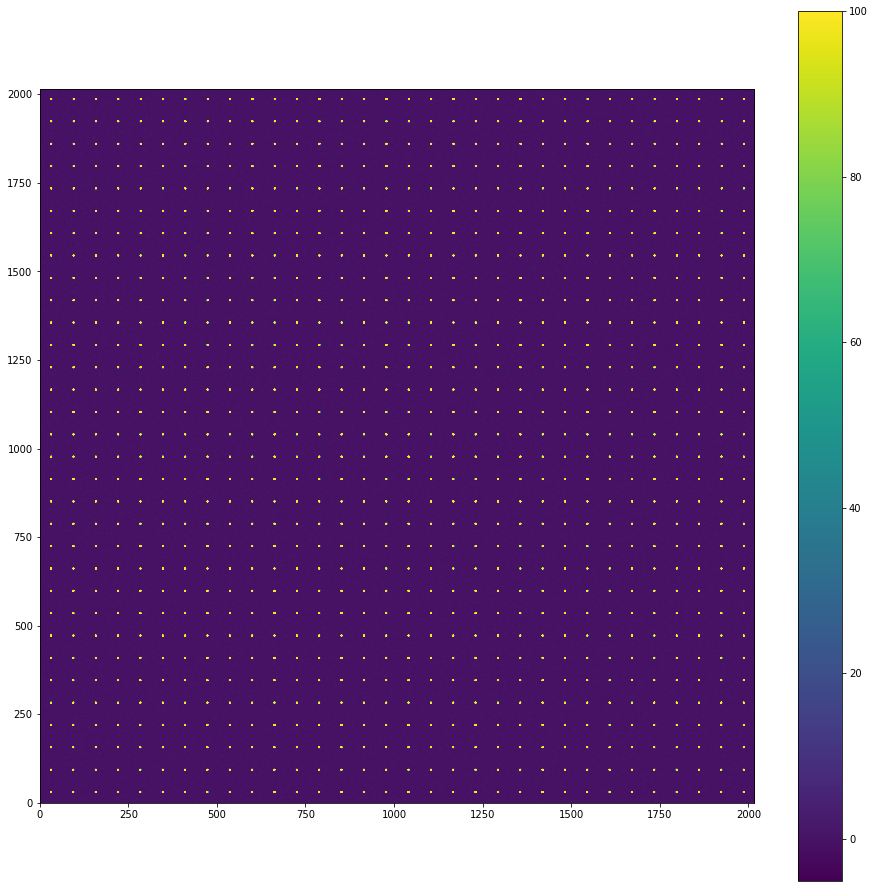

In [10]:
stamp_width=63
read_noise=1.0
sky_level_pixel=0.0
ugal=UndersampledGalSim(stamp_width=stamp_width,read_noise=read_noise,method_of_imaging='phot',
                         sky_level_pixel=sky_level_pixel,do_hsm_moments_truefalse=False)

tstart=time.time()
cat_in=ugal.make_minmax_catalog(n_per_side=32,offsetx_minmax=(-.5,.5),offsety_minmax=(-.5,.5),
                                sigma_minmax=(.4,.4),ell_minmax=(0,0),
                                angle_minmax=(0,0),flux_minmax=(1e5,1e5))

mosaic,cat_in=ugal.make_mosaic(cat_in)
print(time.time()-tstart," to simulate ",str(len(cat_in))," galaxies")

plt.figure(figsize=(16,16))
plt.imshow(mosaic,origin='lower',vmax=100),plt.colorbar()

In [11]:
# make a directory to write the image to
username=os.environ.get('USERNAME')
mo_dir='/home/'+username+'/DATA/moments/'
if not os.path.exists(mo_dir):
    ! mkdir /home/$USER/DATA/moments/
fits.writeto(mo_dir+'mosaic_centroids.fits',mosaic,overwrite=True)

## Running the stack on the simulation mosaic

In [12]:
def stack_char_and_cal_catalog(fitsfilename):
    from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
    from lsst.pipe.tasks.calibrate import CalibrateTask, CalibrateConfig
    import lsst.afw.image as afwImage
    import lsst.meas.extensions.shapeHSM
    hsm_plugins = set([
        "ext_shapeHSM_HsmShapeBj",      # Bernstein & Jarvis 2002
        "ext_shapeHSM_HsmShapeLinear",  # Hirata & Seljak 2003
        "ext_shapeHSM_HsmShapeKsb",     # KSB 1995
        "ext_shapeHSM_HsmShapeRegauss", # Hirata & Seljak 2003
        "ext_shapeHSM_HsmSourceMoments",# Not PSF corrected; used by all of the above
        "ext_shapeHSM_HsmPsfMoments",   # Moments of the PSF, used by all of the above
    ])
    # first set a few configs
    charConfig = CharacterizeImageConfig()
    #this set the fwhm of the simple PSF to that of optics
    charConfig.installSimplePsf.fwhm = .05 #was .05
    charConfig.doMeasurePsf = False
    charConfig.doApCorr = False # necessary
    charConfig.repair.doCosmicRay = False  
    charConfig.detection.background.binSize = 10   # worth playing around with
    #charConfig.background.binSize = 50
    charConfig.detection.minPixels = 1   # also worth playing around with
    charConfig.measurement.plugins.names |= hsm_plugins   # adding in hsm moments
    charTask = CharacterizeImageTask(config=charConfig)
    
    calConfig = CalibrateConfig()
    calConfig.doAstrometry = False
    calConfig.doPhotoCal = False
    calConfig.doApCorr = False
    calConfig.doDeblend = False   # these are well-separated objects
    # these images should have a uniform background, so measure it
    #  on scales which are larger than the objects
    calConfig.detection.background.binSize = 50
    calConfig.detection.minPixels = 1

    calConfig.measurement.plugins.names |= hsm_plugins
    
    #tstart=time.time()
    image_array=afwImage.ImageF.readFits(fitsfilename)
    image = afwImage.ImageF(image_array)

    exposure = afwImage.ExposureF(image.getBBox())
    exposure.setImage(image)

    #updateVariance(exposure.maskedImage, gain, readNoise)
    charResult = charTask.run(exposure)  
    calTask = CalibrateTask(config= calConfig, icSourceSchema=charResult.sourceCat.schema)
    calResult = calTask.run(charResult.exposure, background=charResult.background, 
                            icSourceCat = charResult.sourceCat)

    #src_sim=calResult.sourceCat.copy()
    return calResult.sourceCat

# display some of the source catalog measurements filtered by searchword
def search_source_schema(src,searchword):
    names=[]
    for name in src.schema.getOrderedNames():
        if searchword in name.lower():
            names.append(name)
    return names

In [13]:
tstart=time.time()
cat_stack=stack_char_and_cal_catalog(mo_dir+'mosaic_centroids.fits')
print("char. & calib. took ",str(time.time()-tstart)[:4]," seconds to measure ",len(cat_stack)," objects ")

char. & calib. took  13.4  seconds to measure  1127  objects 


### Merge in stack measurements to catalog

In [14]:
def match_cats_in_out(x_in,y_in,x_out,y_out,dist_match_max=1):
    inds_in,inds_out=[],[]
    for i in range(len(x_in)):
        g_out=np.where(np.sqrt((x_out-x_in[i])**2+(y_out-y_in[i])**2)<dist_match_max)[0]
        if len(g_out) == 1:
            inds_in.append(i)
            inds_out.append(g_out)
    inds_in,inds_out=np.array(inds_in),np.concatenate(inds_out)
    return inds_in,inds_out

def add_catalog_columns(cat_in,colname,values,indices):
    if colname not in cat_in.dtype.names:
        cat_new = np.zeros(cat_in.shape, dtype=np.dtype(cat_in.dtype.descr+[(colname, 'f8')]))
    else: cat_new = cat_in
    for name in cat_in.dtype.names:
        cat_new[name]=cat_in[name]
    cat_new[colname][indices]=values
    return cat_new

In [15]:
cat=cat_in.copy()
cen_key_x,cen_key_y='base_SdssShape_x','base_SdssShape_y'
cat_new=cat_stack.copy()
cat_inds,new_inds=match_cats_in_out(cat['x'],cat['y'],cat_new[cen_key_x],cat_new[cen_key_y],dist_match_max=1)
print(len(cat_inds),len(new_inds))

keys_in='base_SdssShape_x','base_SdssShape_y','base_SdssCentroid_x','base_SdssCentroid_y'
keys_to_add=keys_in

for key_to_add,key_in in zip(keys_to_add,keys_in):
    cat=add_catalog_columns(cat,key_to_add,cat_new[key_in][new_inds],cat_inds)

1024 1024


/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


In [16]:
cat.dtype

dtype([('x', '<f8'), ('y', '<f8'), ('xsub', '<f8'), ('ysub', '<f8'), ('sigma', '<f8'), ('ell', '<f8'), ('angle', '<f8'), ('flux', '<f8'), ('sigma_hsm', '<f8'), ('ell_hsm', '<f8'), ('angle_hsm', '<f8'), ('flux_hsm', '<f8'), ('xc_hsm', '<f8'), ('yc_hsm', '<f8'), ('base_SdssShape_x', '<f8'), ('base_SdssShape_y', '<f8'), ('base_SdssCentroid_x', '<f8'), ('base_SdssCentroid_y', '<f8')])

## Measurement using sextractor wrapper

## Measure moments using a non-adaptive method, radially weighting by the input Gaussian $\sigma$ multiplied by a factor

In [17]:
nobjs=len(cat_in)
xcfoo1,ycfoo1=np.ones(nobjs)*np.NaN,np.ones(nobjs)*np.NaN#
xcfoo2,ycfoo2=np.ones(nobjs)*np.NaN,np.ones(nobjs)*np.NaN#
thresh=0
winsize=10
factor1=2
factor2=5

for i in range(nobjs):
    xcfoo1[i],ycfoo1[i]=calc_firstmoms(mosaic,(cat_in['x'][i],cat_in['y'][i]),winsize,thresh,cat_in['sigma'][i]*factor1)
    xcfoo2[i],ycfoo2[i]=calc_firstmoms(mosaic,(cat_in['x'][i],cat_in['y'][i]),winsize,thresh,cat_in['sigma'][i]*factor2)
    
cat=add_catalog_columns(cat,'xc_mom1',xcfoo1,np.arange(nobjs))
cat=add_catalog_columns(cat,'yc_mom1',ycfoo1,np.arange(nobjs))
cat=add_catalog_columns(cat,'xc_mom2',xcfoo2,np.arange(nobjs))
cat=add_catalog_columns(cat,'yc_mom2',ycfoo2,np.arange(nobjs))

print(cat.dtype)


[('x', '<f8'), ('y', '<f8'), ('xsub', '<f8'), ('ysub', '<f8'), ('sigma', '<f8'), ('ell', '<f8'), ('angle', '<f8'), ('flux', '<f8'), ('sigma_hsm', '<f8'), ('ell_hsm', '<f8'), ('angle_hsm', '<f8'), ('flux_hsm', '<f8'), ('xc_hsm', '<f8'), ('yc_hsm', '<f8'), ('base_SdssShape_x', '<f8'), ('base_SdssShape_y', '<f8'), ('base_SdssCentroid_x', '<f8'), ('base_SdssCentroid_y', '<f8'), ('xc_mom1', '<f8'), ('yc_mom1', '<f8'), ('xc_mom2', '<f8'), ('yc_mom2', '<f8')]


## Plotting the centroid bias

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/

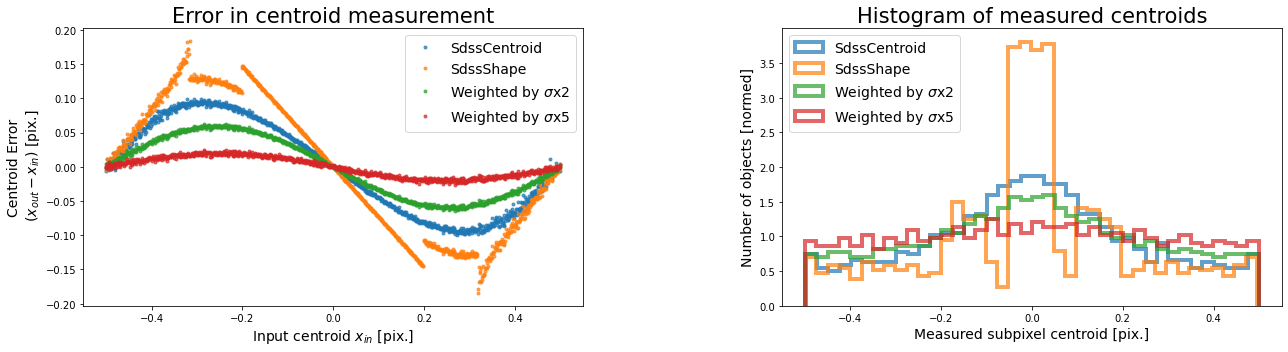

In [18]:
plotlabels=['SdssCentroid','SdssShape','Weighted by $\\sigma$x'+str(factor1),'Weighted by $\\sigma$x'+str(factor2)]
#cenkeys=['yc_sex','base_SdssCentroid_y','base_SdssShape_y','yc_mom']
cenkeys=['base_SdssCentroid_y','base_SdssShape_y','yc_mom1','yc_mom2']
lw,alpha=4,.7
nbins=40
fs=14
plt.figure(figsize=(18,5))
for plotlabel,cenkey in zip(plotlabels,cenkeys):
    plt.subplot(121)
    plt.plot(cat['y']-np.floor(cat['y']+.5),cat[cenkey]-cat['y'],'o',markersize=3,alpha=alpha,label=plotlabel)
    plt.subplot(122)
    plt.hist(cat[cenkey]-np.floor(cat[cenkey]+.5),bins=nbins,label=plotlabel,histtype='step',lw=lw,alpha=alpha,density=True)
plt.subplot(121),plt.title('Error in centroid measurement',fontsize=fs*1.5)
plt.legend(fontsize=fs)
plt.ylabel('Centroid Error\n $(x_{out}-x_{in})$ [pix.]',fontsize=fs)
plt.xlabel('Input centroid $x_{in}$ [pix.]',fontsize=fs)
plt.subplot(122),plt.title('Histogram of measured centroids',fontsize=fs*1.5)
plt.legend(fontsize=fs,loc='upper left')
plt.ylabel('Number of objects [normed]',fontsize=fs)
plt.xlabel('Measured subpixel centroid [pix.]',fontsize=fs)
plt.tight_layout(),plt.subplots_adjust(wspace=.4)
plt.savefig(mo_dir+'/biased_moments-centroid.png',dpi=150)

# Size bias
Making a mosaic of spots with a range of input sizes $\sigma$, takes about a minute for 100 objects with 5 million photons

42.16558909416199  to simulate  100  galaxies


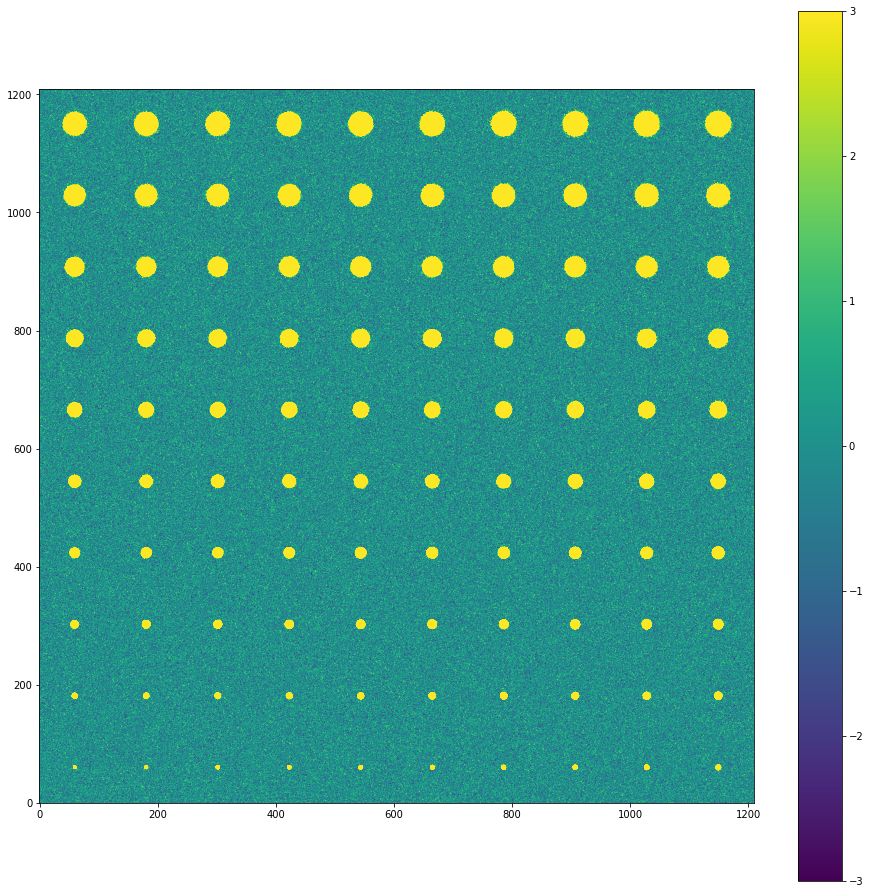

In [19]:
stamp_width=121
read_noise=1.0
sky_level_pixel=0.0
ugal=UndersampledGalSim(stamp_width=stamp_width,read_noise=read_noise,method_of_imaging='phot',
                         sky_level_pixel=sky_level_pixel,do_hsm_moments_truefalse=False)
# method='real_space' takes forever...

tstart=time.time()
cat_in=ugal.make_minmax_catalog(n_per_side=10,offsetx_minmax=(0,0),offsety_minmax=(0,0),
                                sigma_minmax=(.5,5.0),ell_minmax=(0,0),
                                angle_minmax=(0,0),flux_minmax=(5e6,5e6))

mosaic,cat_in=ugal.make_mosaic(cat_in)
print(time.time()-tstart," to simulate ",str(len(cat_in))," galaxies")

noise_level=np.sqrt(read_noise**2+sky_level_pixel**2)
plt.figure(figsize=(16,16))
plt.imshow(mosaic,origin='lower',vmin=-3*noise_level,vmax=3*noise_level),plt.colorbar()
#plt.plot(cat_in['x'],cat_in['y'],'r.')

fits.writeto(mo_dir+'mosaic_sizes.fits',mosaic,overwrite=True)

In [20]:
# run the stack on the mosaic
tstart=time.time()
cat_stack=stack_char_and_cal_catalog(mo_dir+'/mosaic_sizes.fits')
print("char. & calib. took ",str(time.time()-tstart)[:4]," seconds to measure ",len(cat_stack)," objects ")

# add in the measurements
cat=cat_in.copy()
cat_new=cat_stack.copy()
cen_key_x,cen_key_y='base_SdssShape_x','base_SdssShape_y'

cat_inds,new_inds=match_cats_in_out(cat['x'],cat['y'],cat_new[cen_key_x],cat_new[cen_key_y],dist_match_max=1)
print("Number of matches: ",len(cat_inds),len(new_inds))

keys_in=['base_SdssShape_xx','base_SdssShape_yy','base_SdssShape_xy',
         'ext_shapeHSM_HsmSourceMoments_xx','ext_shapeHSM_HsmSourceMoments_yy','ext_shapeHSM_HsmSourceMoments_xy']
keys_to_add=keys_in

for key_to_add,key_in in zip(keys_to_add,keys_in):
    cat=add_catalog_columns(cat,key_to_add,cat_new[key_in][new_inds],cat_inds)
cat['base_SdssShape_xx']=np.sqrt(cat['base_SdssShape_xx'])
cat['base_SdssShape_yy']=np.sqrt(cat['base_SdssShape_yy'])
cat['ext_shapeHSM_HsmSourceMoments_xx']=np.sqrt(cat['ext_shapeHSM_HsmSourceMoments_xx'])
cat['ext_shapeHSM_HsmSourceMoments_yy']=np.sqrt(cat['ext_shapeHSM_HsmSourceMoments_yy'])

char. & calib. took  2.46  seconds to measure  205  objects 
Number of matches:  100 100


/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


In [21]:
# Measure Gaussian weighted moments on the mosaic
nobjs=len(cat_in)
r2foo,x2foo,y2foo,xyfoo=np.ones(nobjs)*np.NaN,np.ones(nobjs)*np.NaN,np.ones(nobjs)*np.NaN,np.ones(nobjs)*np.NaN
thresh=0
winsize=20

for i in range(nobjs):
        r2foo[i],x2foo[i],y2foo[i],xyfoo[i]=calc_secmoms_gwin(mosaic,(cat['x'][i],cat['y'][i]),
                                              winsize,thresh,cat['sigma'][i])

# merge in those measurements
cat=add_catalog_columns(cat,'x2_mom',x2foo,np.arange(nobjs))
cat=add_catalog_columns(cat,'y2_mom',y2foo,np.arange(nobjs))
print(cat.dtype)


[('x', '<f8'), ('y', '<f8'), ('xsub', '<f8'), ('ysub', '<f8'), ('sigma', '<f8'), ('ell', '<f8'), ('angle', '<f8'), ('flux', '<f8'), ('sigma_hsm', '<f8'), ('ell_hsm', '<f8'), ('angle_hsm', '<f8'), ('flux_hsm', '<f8'), ('xc_hsm', '<f8'), ('yc_hsm', '<f8'), ('base_SdssShape_xx', '<f8'), ('base_SdssShape_yy', '<f8'), ('base_SdssShape_xy', '<f8'), ('ext_shapeHSM_HsmSourceMoments_xx', '<f8'), ('ext_shapeHSM_HsmSourceMoments_yy', '<f8'), ('ext_shapeHSM_HsmSourceMoments_xy', '<f8'), ('x2_mom', '<f8'), ('y2_mom', '<f8')]


In [22]:
# Measure Gaussian weighted moments corrected by the pixelization factor
nobjs=len(cat_in)
r2foo,x2foo,y2foo,xyfoo=np.ones(nobjs)*np.NaN,np.ones(nobjs)*np.NaN,np.ones(nobjs)*np.NaN,np.ones(nobjs)*np.NaN
thresh=0
winsize=20

for i in range(nobjs):
        r2foo[i],x2foo[i],y2foo[i],xyfoo[i]=calc_secmoms_corr(mosaic,(cat['x'][i],cat['y'][i]),
                                              winsize,thresh,cat['sigma'][i],
                                              cat['sigma'][i],cat['sigma'][i])

# add these measurements to the catalog
cat=add_catalog_columns(cat,'x2_corr',x2foo,np.arange(nobjs))
cat=add_catalog_columns(cat,'y2_corr',y2foo,np.arange(nobjs))
print(cat.dtype)


[('x', '<f8'), ('y', '<f8'), ('xsub', '<f8'), ('ysub', '<f8'), ('sigma', '<f8'), ('ell', '<f8'), ('angle', '<f8'), ('flux', '<f8'), ('sigma_hsm', '<f8'), ('ell_hsm', '<f8'), ('angle_hsm', '<f8'), ('flux_hsm', '<f8'), ('xc_hsm', '<f8'), ('yc_hsm', '<f8'), ('base_SdssShape_xx', '<f8'), ('base_SdssShape_yy', '<f8'), ('base_SdssShape_xy', '<f8'), ('ext_shapeHSM_HsmSourceMoments_xx', '<f8'), ('ext_shapeHSM_HsmSourceMoments_yy', '<f8'), ('ext_shapeHSM_HsmSourceMoments_xy', '<f8'), ('x2_mom', '<f8'), ('y2_mom', '<f8'), ('x2_corr', '<f8'), ('y2_corr', '<f8')]


## plotting size bias

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/

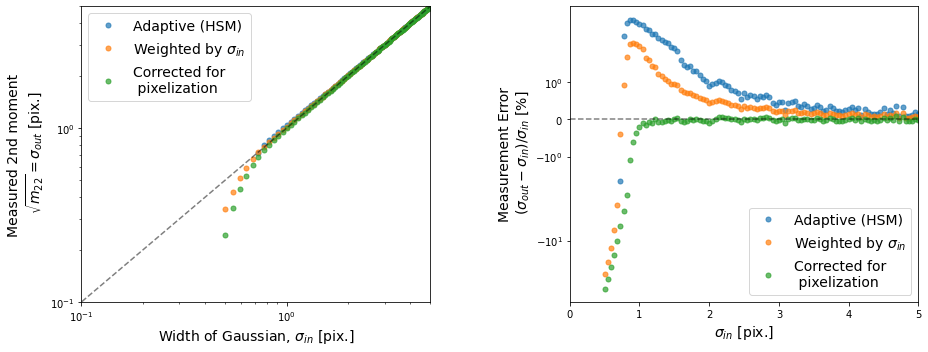

In [23]:
#sigkeys=['x2_sex','ext_shapeHSM_HsmSourceMoments_xx','x2_mom','x2_corr']
sigkeys=['ext_shapeHSM_HsmSourceMoments_xx','x2_mom','x2_corr']
#,'ext_shapeHSM_HsmSourceMoments_xx','base_SdssShape_xx'
plotlabels=['Adaptive (HSM)','Weighted by $\\sigma_{in}$','Corrected for \n pixelization']
#,'ext_HSM'
plt.figure(figsize=(13,5))
for sigkey,plotlabel in zip(sigkeys,plotlabels):
    plt.subplot(121)
    plt.plot(cat['sigma'],cat[sigkey],'o',
             alpha=.7,label=plotlabel,markersize=5)
    plt.subplot(122)
    plt.plot(cat['sigma'],(cat[sigkey]-cat['sigma'])/cat['sigma']*100.,'o',
             alpha=.7,label=plotlabel,markersize=5)



plt.subplot(121),plt.axis([.1,5,.1,5])
plt.ylabel('Measured 2nd moment\n $\sqrt{m_{22}} = \sigma_{out}$ [pix.]',fontsize=fs)
plt.xlabel('Width of Gaussian, $\sigma_{in}$ [pix.]',fontsize=fs)
plt.xscale('log'),plt.yscale('log')
plt.plot([0,5],[0,5],linestyle='--',color='k',alpha=.5)
plt.legend(fontsize=fs,loc='upper left')
plt.subplot(122)
plt.yscale('symlog')#
#plt.ylim(1e-4,1e2),plt.yscale('log')
plt.axhline(0,linestyle='--',alpha=.5,color='k')
plt.legend(fontsize=fs,loc='lower right')
plt.xlim(0,5)
#plt.xscale('log')
plt.ylabel('Measurement Error\n $(\sigma_{out}-\sigma_{in})/\sigma_{in}$ [%]',fontsize=fs)
plt.xlabel('$\sigma_{in}$ [pix.]',fontsize=fs)
plt.tight_layout(),plt.subplots_adjust(wspace=.4)
plt.savefig(mo_dir+'/biased_moments-size.png',dpi=150)